In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve


In [58]:
# Logistic Regression on CHC and CCK

data = data[(data["classe_name"] == "CHC") | (data["classe_name"] == "CCK")]
data = data.replace("CHC", 0)
data = data.replace("CCK", 1)

X = data.drop(["classe_name"], axis = 1)
y = data["classe_name"]

print("Training on CHC and CCK")
print("Number of CHC: ", len(data[data["classe_name"] == 0]))
print("Number of CCK: ", len(data[data["classe_name"] == 1]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

print("Seperate training and test set")
print("Number of CHC in training set: ", len(y_train[y_train == 0]))
print("Number of CCK in training set: ", len(y_train[y_train == 1]))
print("Number of CHC in test set: ", len(y_test[y_test == 0]))
print("Number of CCK in test set: ", len(y_test[y_test == 1]))

logreg = LogisticRegression(class_weight={0: 1, 1: 4}, penalty='l1', solver='liblinear')
logreg.fit(X_train, y_train)

# Predict on training set
y_pred = logreg.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
#print confusion matrix
print(confusion_matrix(y_test, y_pred))

# Get the weights of the model in a dataframe
weights = logreg.coef_[0]
weights = pd.DataFrame(weights)
weights = weights.transpose()
weights.columns = X.columns
weights = weights.transpose()
weights.columns = ["weights"]
weights = weights.sort_values(by=['weights'], ascending=False)



Training on CHC and CCK
Number of CHC:  66
Number of CCK:  16
Seperate training and test set
Number of CHC in training set:  46
Number of CCK in training set:  11
Number of CHC in test set:  20
Number of CCK in test set:  5
Accuracy: 0.88
[[17  3]
 [ 0  5]]


<Axes: >

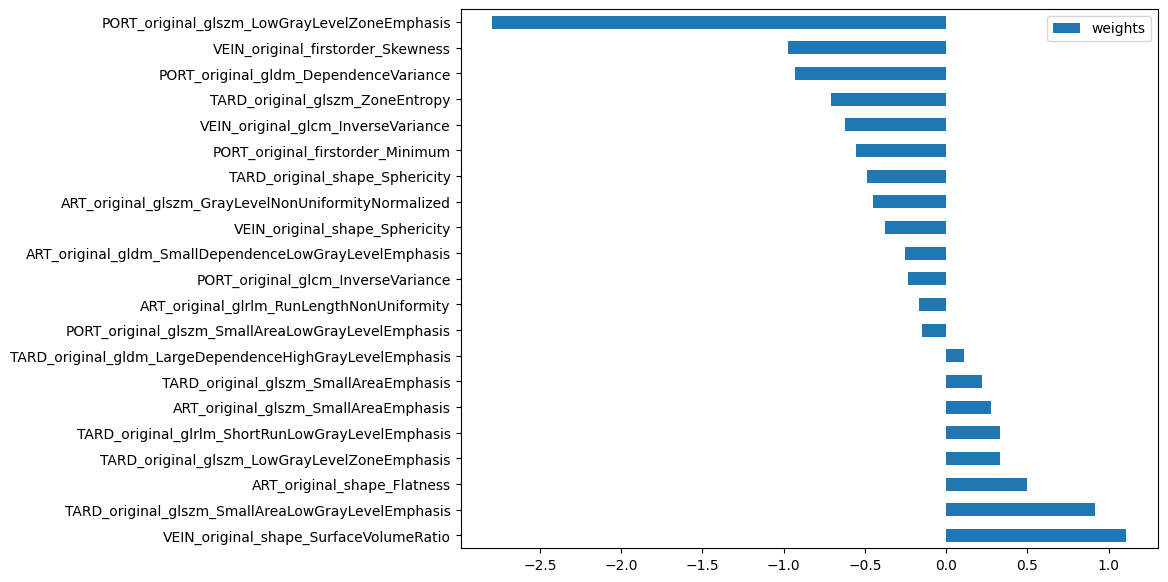

In [60]:
weights[np.abs(weights["weights"]) > 0.1].plot.barh(figsize=(9, 7))

From now on we will keep only those 17 variables

In [61]:
very_few_features_names = weights[np.abs(weights["weights"]) > 0.3].index.tolist()

few_data = data[very_few_features_names + ["classe_name"]]


Text(0.5, 1.0, 'ROC Curve Positive Class: CCK Negative Class: CHC')

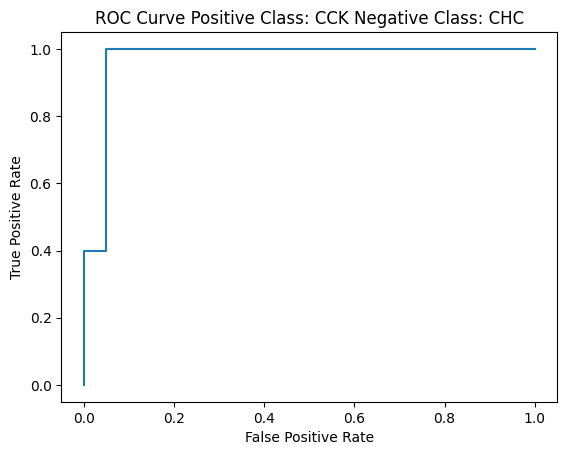

In [64]:
# Retrain the model with the few features
X = few_data.drop(["classe_name"], axis = 1)
y = few_data["classe_name"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

logreg = LogisticRegression(class_weight={0: 1, 1: 4})
logreg.fit(X_train, y_train)

y_pred_proba = logreg.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test,  y_pred_proba, pos_label=1)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Positive Class: CCK Negative Class: CHC')


In [51]:
# Checking the variability of the coefficients

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=20, n_repeats=3, random_state=1)
scores = cross_validate(logreg, X, y, cv=cv, n_jobs=2,return_estimator=True)

coefs = pd.DataFrame(
    [
        est.coef_[0] for est, (train_idx, _) in zip(scores["estimator"], cv.split(X, y))
    ],
    columns=very_few_features_names,
)

In [138]:
coefs.head()

,VEIN_original_shape_SurfaceVolumeRatio,TARD_original_glszm_SmallAreaLowGrayLevelEmphasis,ART_original_shape_Flatness,TARD_original_glszm_LowGrayLevelZoneEmphasis,VEIN_original_shape_Sphericity,ART_original_glszm_GrayLevelNonUniformityNormalized,TARD_original_shape_Sphericity,PORT_original_firstorder_Minimum,VEIN_original_glcm_InverseVariance,TARD_original_glszm_ZoneEntropy,PORT_original_gldm_DependenceVariance,VEIN_original_firstorder_Skewness,PORT_original_glszm_LowGrayLevelZoneEmphasis
0,1.259340,0.721551,0.757319,0.309716,-0.816839,-0.572607,-1.158659,-0.366179,-1.052899,-1.293536,-1.429648,-1.027312,-2.475997
1,1.300564,0.708162,0.804648,0.436973,-1.010954,-0.624458,-1.106970,-0.308101,-1.030232,-1.280187,-1.462364,-1.050032,-2.278129
2,1.295784,0.703787,0.748062,0.360924,-0.880683,-0.520265,-1.093613,-0.442914,-1.097091,-1.171787,-1.485730,-1.204458,-2.404633
3,1.267972,0.724425,0.772941,0.296573,-0.923327,-0.572314,-1.070831,-0.354036,-1.063569,-1.292716,-1.422581,-1.081626,-2.483682
4,1.148327,0.717163,0.749753,0.382296,-0.910628,-0.616194,-1.033505,-0.392580,-0.980727,-1.323354,-1.425100,-1.035716,-2.476099


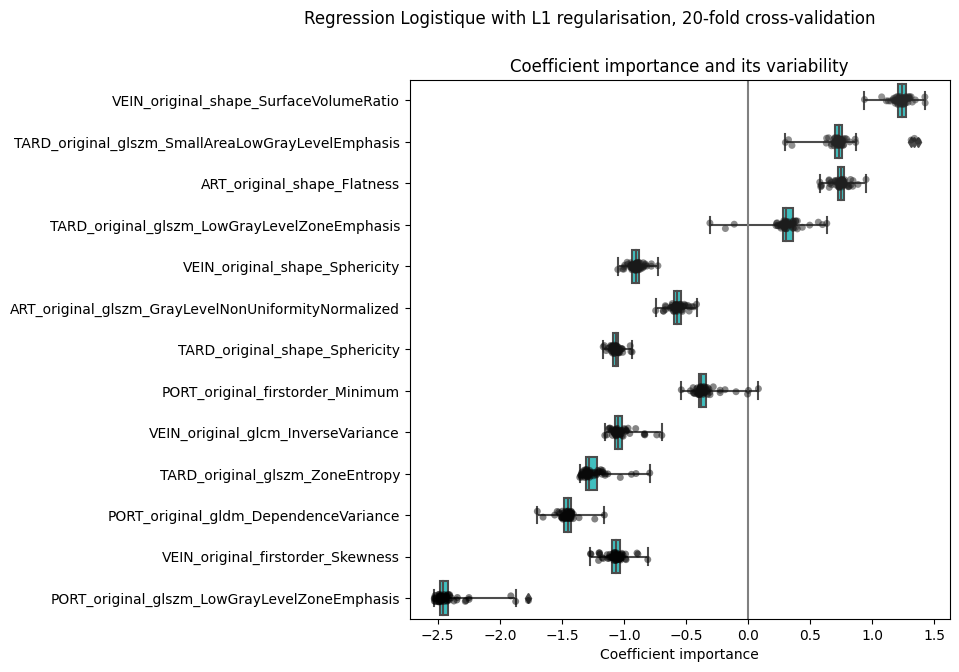

In [52]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Regression Logistique with L1 regularisation, 20-fold cross-validation")
plt.subplots_adjust(left=0.3)

Using statsmodel to do this analysis

In [53]:
very_few_features_names = weights[np.abs(weights["weights"]) > 0.3].index.tolist()

few_data = data[very_few_features_names + ["classe_name"]]

# Change CHC to 0 and CCK to 1
few_data["classe_name"] = few_data["classe_name"].replace(["CHC", "CCK"], [0, 1])

C:\Users\Fotis\AppData\Local\Temp\ipykernel_15736\2301382787.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  few_data["classe_name"] = few_data["classe_name"].replace(["CHC", "CCK"], [0, 1])


In [54]:
import statsmodels.api as sm

X = few_data.drop(["classe_name"], axis = 1)
y = few_data["classe_name"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit_regularized(method="l1", alpha=0.1)
print(result.summary2())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.213486025491668
            Iterations: 138
            Function evaluations: 138
            Gradient evaluations: 138
                                           Results: Logit
Model:                           Logit                       Method:                      MLE       
Dependent Variable:              classe_name                 Pseudo R-squared:            0.678     
Date:                            2023-05-31 10:32            AIC:                         39.9936   
No. Observations:                57                          BIC:                         62.4672   
Df Model:                        10                          Log-Likelihood:              -8.9968   
Df Residuals:                    46                          LL-Null:                     -27.960   
Converged:                       1.0000                      LLR p-value:                 3.9102e-05
No. Iterations:        

Kfold Choice of coefficients

In [72]:
data = pd.read_csv('data/Big_Data.csv')
data = data.dropna()
data = data.drop(["Unnamed: 0"], axis = 1)
data = data.dropna()

In [73]:
data = data[(data["classe_name"] == "CHC") | (data["classe_name"] == "CCK")]
data = data.replace("CHC", 0)
data = data.replace("CCK", 1)

X = data.drop(["classe_name"], axis = 1)
y = data["classe_name"]

In [119]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

logreg = LogisticRegression(class_weight={0: 1, 1: 4})

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_validate(logreg, X, y, cv=cv, n_jobs=2,return_estimator=True)

In [120]:
coefs = pd.DataFrame(
    [
        est.coef_[0] for est, (train_idx, _) in zip(scores["estimator"], cv.split(X, y))
    ],
    columns=X.columns,
    )


In [121]:
coeff_malus = 5

variable_decisions = pd.DataFrame(coefs.apply(lambda x: np.sum(np.abs(x) > 0.3), axis=0))
variable_decisions.columns = ["votes"]

std_malus = coefs.std().apply(lambda x: 2 if x > 0.2 else 1 if x > 0.1 else 0)

variable_decisions["std_malus"] = std_malus

variable_decisions["total score"] = variable_decisions["votes"] - variable_decisions["std_malus"] 


In [122]:
def first_text(x):
    if x.startswith("ART"):
        return "ART"
    elif x.startswith("VEIN"):
        return "VEIN"
    elif x.startswith("PORT"):
        return "PORT"
    elif x.startswith("TARD"):
        return "TARD"

variable_decisions["phase"] = variable_decisions.index.map(first_text)

In [137]:
very_few_variables = variable_decisions[variable_decisions["total score"] > 8]

In [138]:
very_few_variables

,votes,std_malus,total score,phase
ART_original_glszm_GrayLevelNonUniformityNormalized,14,1,13,ART
ART_original_shape_Flatness,10,1,9,ART
ART_original_shape_Sphericity,14,1,13,ART
PORT_original_firstorder_Skewness,11,1,10,PORT
PORT_original_gldm_DependenceVariance,11,1,10,PORT
PORT_original_glrlm_ShortRunLowGrayLevelEmphasis,9,0,9,PORT
PORT_original_glszm_LowGrayLevelZoneEmphasis,15,1,14,PORT
PORT_original_glszm_SmallAreaLowGrayLevelEmphasis,15,1,14,PORT
PORT_original_shape_Sphericity,15,1,14,PORT
VEIN_original_firstorder_Skewness,11,1,10,VEIN


<Axes: xlabel='total score'>

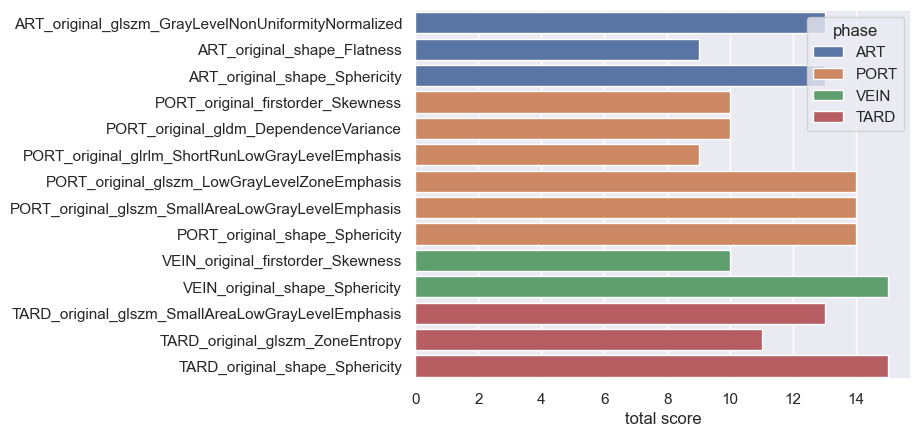

In [139]:
sns.barplot(data = very_few_variables, x = "total score", y=very_few_variables.index , hue="phase", dodge=False)

In [92]:
import statsmodels.api as sm



X = few_data.drop(["classe_name"], axis = 1)
y = few_data["classe_name"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit_regularized(method="l1", alpha=0.1)
print(result.summary2())

AttributeError: 'DataFrame' object has no attribute 'barh'